In [22]:
# Install Detectron2
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-h9pqv8re
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-h9pqv8re
^C
ERROR: Operation cancelled by user


In [23]:
# Import necessary libraries
import os
import torch
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultTrainer, HookBase
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2 import model_zoo
from detectron2.config import get_cfg
import detectron2.utils.comm as comm

In [24]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [25]:
# Check if GPU is available
assert torch.cuda.is_available(), "CUDA is not available. Please enable a GPU Runtime in Kaggle."

In [26]:
# Dataset paths
dataset_path = '/kaggle/input/yolov10-cube-failure-coco-dataset/'
train_json = os.path.join(dataset_path, 'train/_annotations.coco.json')
val_json = os.path.join(dataset_path, 'valid/_annotations.coco.json')
train_images = os.path.join(dataset_path, 'train')
val_images = os.path.join(dataset_path, 'valid')

In [27]:
# Register the dataset in COCO format
register_coco_instances("cube_train", {}, train_json, train_images)
register_coco_instances("cube_val", {}, val_json, val_images)

In [28]:
# Metadata for visualization
cube_metadata = MetadataCatalog.get("cube_train")

In [29]:
# Custom Hook for Loss Evaluation and Logging
class LossEvalHook(HookBase):
    def __init__(self, cfg, model, data_loader):
        self.cfg = cfg.clone()
        self.model = model
        self.data_loader = data_loader

    def after_epoch(self):
        # Run evaluation on the validation set
        evaluator = COCOEvaluator("cube_val", self.cfg, False, output_dir="./output/")
        val_loader = build_detection_test_loader(self.cfg, "cube_val")
        results = inference_on_dataset(self.model, val_loader, evaluator)
        
        # Access the AP, losses, and confidence
        AP50 = results['bbox']['AP50']
        total_loss = self.trainer.storage.latest()['total_loss']
        
        # Log the metrics
        print(f"Epoch {self.trainer.iter // self.trainer.storage.cfg.SOLVER.MAX_ITER + 1} - Loss: {total_loss:.4f}, AP50: {AP50:.4f}")
# Custom Trainer to Include LossEvalHook
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, True, output_dir=cfg.OUTPUT_DIR)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, LossEvalHook(self.cfg, self.model, build_detection_test_loader(self.cfg, "cube_val")))
        return hooks

In [31]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cube_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
#cfg.SOLVER.IMS_PER_BATCH = 1 # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 200   
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (cube).

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [41]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [35]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
predictor = DefaultPredictor(cfg)

/opt/conda/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

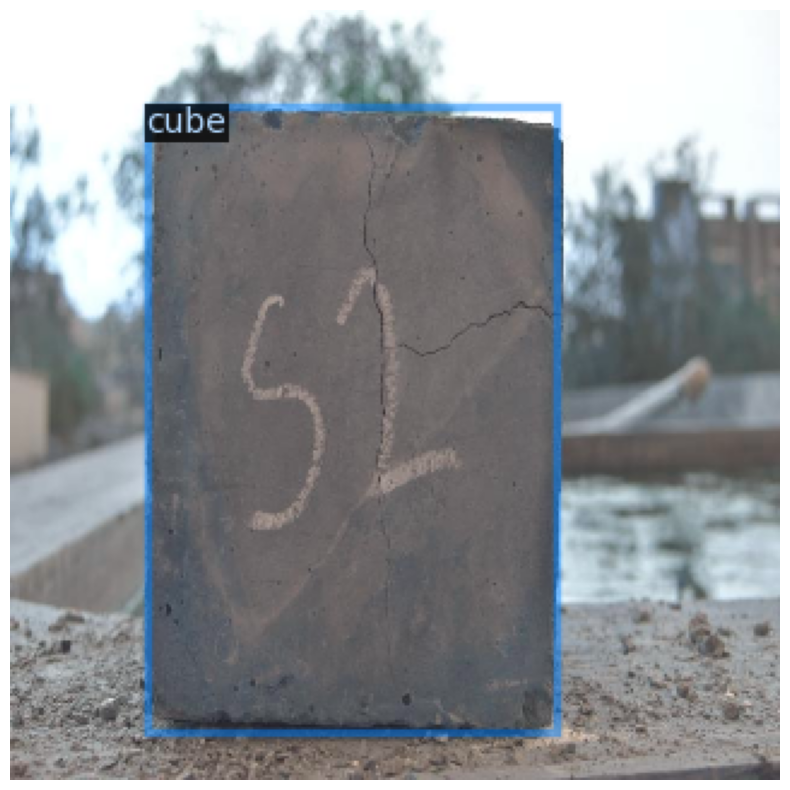

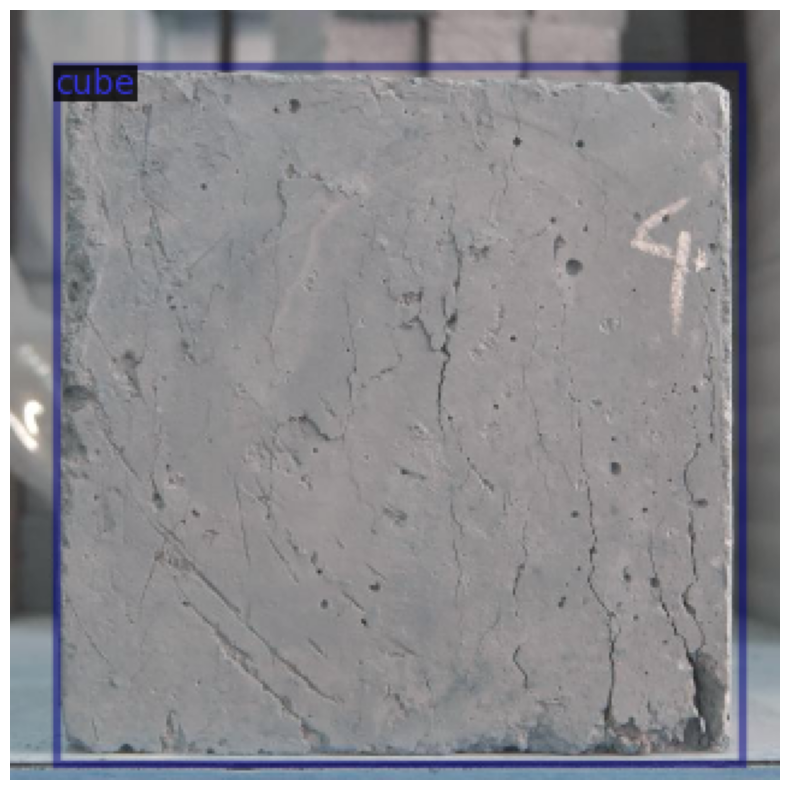

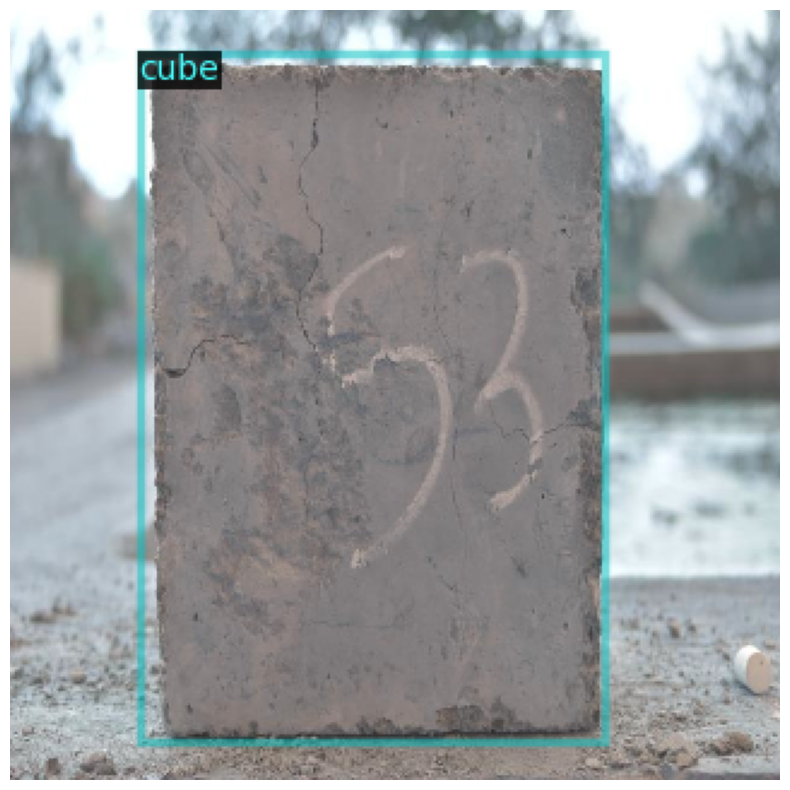

In [38]:
# Visualize Random Samples from Validation Set
dataset_dicts = DatasetCatalog.get("cube_val")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=cube_metadata, scale=0.5, instance_mode=ColorMode.IMAGE)
    vis = visualizer.draw_dataset_dict(d)
    vis_img_rgb = vis.get_image()[:, :, ::-1]
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img_rgb)
    plt.axis('off')
    plt.show()

In [39]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("cube_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "cube_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


OrderedDict([('bbox', {'AP': nan, 'AP50': nan, 'AP75': nan, 'APs': nan, 'APm': nan, 'APl': nan})])
